In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import Dataset, DatasetDict
from transformers import Trainer, TrainingArguments, AdamW, BertForSequenceClassification

C:\Users\hp\Documents\anaconda3\envs\taswiyahmn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('WELFake_Dataset.csv')

In [3]:
df = df.head(500)
df.describe

<bound method NDFrame.describe of      Unnamed: 0                                              title  \
0             0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1             1                                                NaN   
2             2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3             3  Bobby Jindal, raised Hindu, uses story of Chri...   
4             4  SATAN 2: Russia unvelis an image of its terrif...   
..          ...                                                ...   
495         495  Trump ordered to give deposition in Washington...   
496         496  Obama’s Race War Makes Its Way To His Hometown...   
497         497  FACTBOX: About 6.1 million without power in U....   
498         498  OOPS! ABSOLUTELY NO ONE SHOWED UP For NYC Debu...   
499         499  Russia warns Iraq, Kurds not to destabilize Mi...   

                                                  text  label  
0    No comment is expected from Barack Obama Membe...      1

In [4]:
print("Before Preprocessing:")
print(df.head(), "\n")

Before Preprocessing:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1   



In [5]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+", "", x))

df['text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x))
df['text'] = df['text'].apply(lambda x: x.lower())

df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))

df['text'] = df['text'].apply(lambda x: " ".join(x.split()))

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: " ".join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

C:\Users\hp\AppData\Local\Temp\ipykernel_23060\1406373853.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
C:\Users\hp\AppData\Local\Temp\ipykernel_23060\1406373853.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\hp\Documents\anaconda3\envs\taswiyahmn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\Documents\anaconda3\envs\taswiyahmn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hp\Documents\anaconda3\envs\taswiyahmn\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\hp\Documents\anaconda3\envs\taswiyahmn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

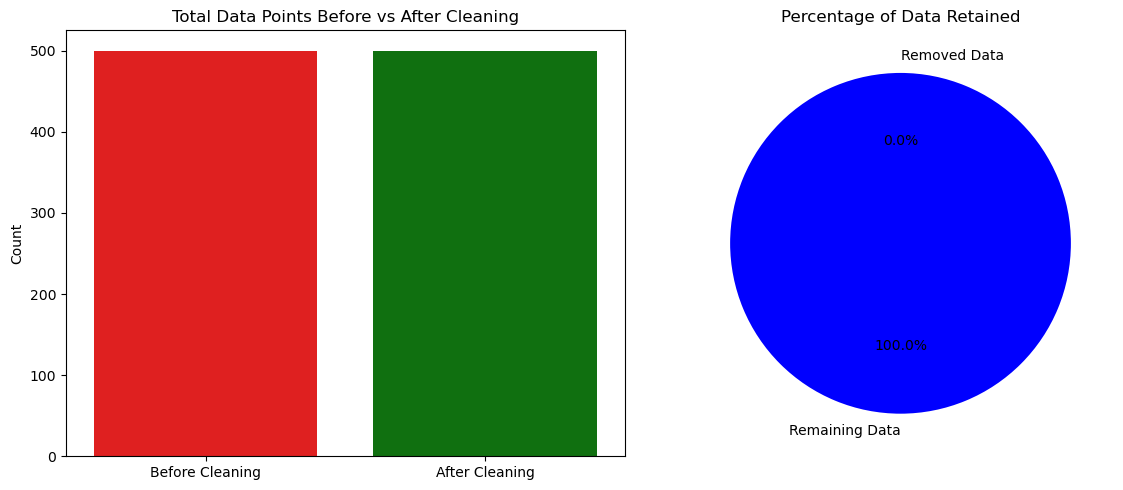

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["text"] = df["text"].astype(str).replace("nan", pd.NA)
total_before = len(df)
df = df.dropna(subset=["text"]).reset_index(drop=True)
total_after = len(df)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart: Total rows before & after cleaning
sns.barplot(x=["Before Cleaning", "After Cleaning"], y=[total_before, total_after], ax=axes[0], palette=["red", "green"])
axes[0].set_title("Total Data Points Before vs After Cleaning")
axes[0].set_ylabel("Count")

# Pie chart: Percentage of data removed
labels = ["Remaining Data", "Removed Data"]
sizes = [total_after, total_before - total_after]
colors = ["blue", "orange"]

axes[1].pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90)
axes[1].set_title("Percentage of Data Retained")

plt.tight_layout()
plt.show()

In [7]:
print("After Preprocessing:")
print(df.head())

After Preprocessing:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  comment expect barack obama member fyf fukyofl...      1  
1                          post vote hillari alreadi      1  
2  demonstr gather last night exercis constitut p...      1  
3  dozen polit activ pastor came privat dinner fr...      0  
4  rs sarmat missil dub satan replac ss fli mile ...      1  


In [8]:
# print(type(df.loc[325, "text"])) 